# Term Deposit Marketing - An Apziva Project

# Modeling

By Samuel Alter

Apziva: G3SuQYZYrFt9dwF3

## Project Overview

Using phone call data from a European bank, this project will be building a model that predicts if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

### Goals

The startup is hoping that I can **achieve ≥81% accuracy** using a 5-fold cross validation strategy, taking the average performance score.

Bonus goals include:
* Determining which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

### The dataset

Using phone call data from a European bank, this project will be building models that predict if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

The dataset consists of the following columns:
* `age`
  * Numeric
  * The age of the customer
* `job`
  * Categorical
  * The job category of the customer
* `marital`
  * Categorical
  * Whether the customer is married
* `education`
  * Categorical
  * The customer's level of education
* `default`
  * Binary
  * If the customer has credit in default or not
* `balance`
  * Numeric
  * Average yearly balance in Euros
* `housing`
  * Binary
  * If the customer has a housing loan or not
* `loan`
  * Binary
  * If the customer has a personal loan
* `contact`
  * Categorical
  * The type of contact communication
* `day`
  * Numeric
  * Last contact day of the month
* `month`
  * Categorical
  * Last contact month of the year
* `duration`
  * Numeric
  * Duration of the last phone call with the customer
* `campaign`
  * Numeric
  * The number of contacts performed during this campaign and for this client, which includes the last contact

The final column, `y`, is the target of the dataset and shows whether the client subscribed to a term deposit.

## Imports and Helper Functions

In [222]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
import threading
from datetime import datetime
# from contextlib import contextmanager
from timeit import default_timer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,cross_val_score
# from pycaret.classification import setup,compare_models,create_model,plot_model,evaluate_model
# from pycaret.regression import *

# from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import sklearn.lda.LDA as LDA # <-- this is throwing the ModuleNotFoundError

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from collections import defaultdict

import shap

In [7]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [8]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    SOURCE: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [9]:
seed=rand_gen()
seed

4769

In [10]:
test_size=0.2
test_size

0.2

In [11]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x16984BAC0

In [12]:
import json
from pathlib import Path
import inspect

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [13]:
# read in data
df=pd.read_csv('../data/2_data.csv')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no


## Goals recap

To achieve this project's goals, we have to run models. As a reminder, this project is aiming to predict customer behavior. Specifically, we are training models to determine if a customer will buy a term deposit loan.

We are aiming to achieve ≥81% accuracy with the modeling
  * Use a 5-fold cross validation strategy and take the average performance score.

Bonus goals include:
* Determine which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

## Will a Customer Receive a Loan?
`AutoSklearn` to  `Optuna` to `scikit-learn`: the Modeling Workflow

I will first use [`AutoSklearn`](#https://automl.github.io/auto-sklearn/master/#) to help me explore the ML algorithm landscape to identify the best-performing models for this particular dataset.

In order to find the best hyperparameters for our modeling, I will use [`Optuna`](#https://optuna.readthedocs.io/en/stable/index.html). This is similar to other frameworks like [`Hyperopt`](#http://hyperopt.github.io/hyperopt/), which are designed to quickly and efficiently find the best hyperparameters for your dataset.

Finally, we will use `sklearn` to build the final, optimized model.

### Notes on project setup:

We want to help the bank understand which customers are most likely to purchase the financial product. Knowing this would save the bank time and money. The dataset that we were given consists of demographic (and banking) data (like `age`,`job`,`marital`,and `balance`) as well as campaign-specific information (like `contact`,`day`,and `duration`).

*Demographic and Banking Data*
* `age`
* `job`
* `marital`
* `education`
* `default`
* `balance`
* `housing`
* `loan`

*Campaign-Specific Data*
* `contact`
* `day`
* `month`
* `duration`
* `campaign`

*Target Feature*
* `y`

We want to build a three-layered ML system that helps answer the project goals:
1. Understand which kinds of customers that they should call
 1. I will **not** give the model access to the campaign call data
1. After the initial calls, understand which customers the company should keep calling
 1. Give the model access to the campaign call data
1. Build a model using unsupervised learning to learn about clusters of customers in the dataset

**Layer 1**:  

Use `X_1` to model which customers to make calls to. We are training a model that does not know any call data, so this is *before* making calls.

**Layer 2**:  

Use the full `X` dataset (for clarity in its use in the layer flow, we'll be using `X_2` to model which customers the company should keep calling.

**Layer 3**:  

Use unsupervised learning to uncover how the customers are grouped.

### Setup X

In [19]:
dbd=[ # demographic and banking data
    'age',
    'job',
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan'
]

csd=[ # campaign-specific data
    'contact',
    'day',
    'month',
    'duration',
    'campaign'
]

`_1` refers to the first layer of the model, consisting of demographic and banking data, not including data related to the campaign. This simulates new customers that haven't received a call yet. This helps answer the main question of the project, namely to train a model that predicts which customer will receive a loan.

In [20]:
X_1=df[[col for col in df.columns if col != 'y' and col not in csd]]
y=df['y']
y=y.map({'yes':1,'no':0})

`_2` refers to the second layer of the model, consisting of all columns. This helps answer the first bonus question of the project, which is to determine which customers the bank should prioritize calling to: those most likely to receive a loan.

In [21]:
X_2=df[[col for col in df.columns if col != 'y']]

`_3` refers to the third layer of the model, consisting of all columns. This helps answer the another bonus question: can we train an unsuperived learning model that groups the customers into categories?

In [22]:
X_3=df[[col for col in df.columns if col != 'y']]

In [23]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


Make function to automate the training of the AutoSklearn pipeline:

In [16]:
def detectCatCont(X,verbose=False):
    '''
    Helper function for detecting categorical and continuous
    features in a dataset. It returns the categorical and
    continuous features as a tuple.
    '''

    # detect categorical and continuous features
    categorical_features = X.select_dtypes(
        include=['object', 'category']).columns.tolist()
    continuous_features = X.select_dtypes(
        include=['int64', 'float64']).columns.tolist()

    if verbose:
        print('Categorical and continuous features detected')

    return categorical_features,continuous_features

In [17]:
def defPreprocessor(categorical_features,continuous_features,verbose=False,custom_preprocessor=None):
    '''
    Helper function for returning a custom preprocessor for
    processing a dataframe, or one that is defined
    within the function. It returns the custom or
    function-created preprocessor.
    '''

    if custom_preprocessor is not None:
        if verbose:
            print('Using custom preprocessor')
        return custom_preprocessor

    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_features),
            ('num', StandardScaler(), continuous_features)
        ]
    )

    if verbose:
        print('Preprocessor created')
        print('categorical_features:', categorical_features)
        print('continuous_features:', continuous_features)

    return preprocessor

In [18]:
def trainTestSplits(X,y,test_size,seed,verbose=False):
    '''
    Helper function that automates the train_test_split function within scikit-learn
    and returns them as a dictionary.
    '''

    # create train/test splits
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size=test_size, random_state=seed,stratify=y)

    if verbose:
        print('Training and testing splits created')

    splits={
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test
        }

    return splits

In [19]:
def defPipeline(time_for_task,seed,preprocessor,verbose=False):
    '''
    Helper function that creates the pipeline from a previously-defined
    preprocessor. Returns the pipeline.
    '''

    # Define Auto-sklearn classifier and pipeline
    automl = AutoSklearnClassifier(
        time_left_for_this_task=time_for_task,
        seed=seed
    )
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', automl)
        ]
    )

    if verbose:
        print('AutoSklearnClassifier and pipeline created')

    return pipeline

In [20]:
def evaluateModel(X_test,y_test,pipeline,verbose=False):
    '''
    Helper function that returns a tuple of predictions on
    the model and the accuracy.
    '''

    # evaluate the model
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if verbose:
        print(f"AutoSklearn accuracy:\n{accuracy*100:.2f}%")

    return y_pred,accuracy

In [21]:
def returnTopModels(pipe_path,score=0.9):
    '''
    Returns the most common classifiers achieving a mean_test_score of over 90% accuracy.
    This value can be changed in the function.
    '''

    # load pipeline and splits
    pipeline=joblib.load(pipe_path)

    # access the AutoSklearnClassifier from the pipeline
    automl_model = pipeline.named_steps['classifier']

    # access the cross-validation results
    cv_results=pd.DataFrame(automl_model.cv_results_)

    cv_results_=\
        cv_results[
            (cv_results['status'] == 'Success') & \
            (cv_results['mean_test_score']>score)
        ]\
    .sort_values(by='mean_test_score', ascending=False)

    cv_results_over90=cv_results_['param_classifier:__choice__'].value_counts()

    return cv_results_over90

In [22]:
def run_autosklearn_pipeline(X,y,seed,test_size,save_location,filename,verbose=False,time_for_task=3600,return_tops=True):
    '''
    Function that runs the AutoSklearnClassifier.
    Outputs a dictionary of the test_train_split'ed dataset ("splits")
    and the created pipeline object.

    It also returns the top-performing models
    that achieve an accuracy of over 90%.

    Arguments:
    X - the features dataset
    y - the target dataset
    seed - the random seed
    test_size - the test_size fraction for train_test_split
    save_location - the location where the splits and pipeline are located
    filename - what to call these two objects
    verbose - verbosity flag
    time_for_task - using the AutoSklearnClassifier default value

    Outputs:
    splits - a dictionary of X_train,X_test,y_train,y_test
    pipeline - the trained AutoSklearnClassifier pipeline
    '''

    categorical_features,continuous_features=detectCatCont(X,verbose)

    preprocessor=defPreprocessor(categorical_features,continuous_features,verbose)

    splits=trainTestSplits(X,y,test_size,seed,verbose)

    X_train=splits['X_train']
    X_test=splits['X_test']
    y_train=splits['y_train']
    y_test=splits['y_test']

    pipeline=defPipeline(time_for_task,seed,preprocessor,verbose)

    # start training
    if verbose:
        print(f"\nTraining the pipeline... (This may take up to {time_for_task//60} minutes)\n")
        print()
    pipeline.fit(X_train, y_train)

    # training complete
    if verbose:
        print("\nTraining complete.")

    y_pred,accuracy=evaluateModel(X_test,y_test,pipeline,verbose)

    pipe_path=f'{save_location+filename}'

    # save pipeline
    joblib.dump(pipeline,pipe_path)

    if verbose:
        print(f'saved pipeline here:\n{pipe_path}')

    splits_path=f'{save_location+filename}_splits'

    # save splits
    joblib.dump(splits,splits_path)

    if verbose:
        print(f'saved splits here:\n{splits_path}')

    if return_tops:
        cv_results_over90=returnTopModels(pipe_path)
        return splits,pipeline,cv_results_over90

    return splits,pipeline

### Layer 1: Using only the demographic and banking data

#### `AutoSklearn`

In [23]:
seed

4436

Note: I set the seed to a specific number because training the model takes time and I want to proceed with the rest of the project. This number was chosen randomly previously.

In [24]:
test_size

0.2

In [25]:
X_1.head(3)

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes


In [ ]:
# run function for layer_1
splits_1,pipeline_1,results_1=\
run_autosklearn_pipeline(X=X_1,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer1',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan']
continuous_features: ['age', 'balance']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)


[WARNING] [2024-08-22 03:13:33,051:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:13:33,765:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-08-22 03:14:17,146:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:14:31,188:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2024-08-22 03:20:32,566:Client-EnsembleBuilder] No mo

In [ ]:
# see top-performing models
results_1=returnTopModels('../joblib/2_pipeline_20240821_layer1')
results_1

random_forest          14
passive_aggressive      9
mlp                     5
adaboost                5
bernoulli_nb            4
k_nearest_neighbors     3
extra_trees             2
sgd                     1
liblinear_svc           1
lda                     1
Name: param_classifier:__choice__, dtype: int64

In [2]:
# load objects
pipeline_1=joblib.load('../joblib/2_pipeline_20240821_layer1')
splits_1=joblib.load('../joblib/2_pipeline_20240821_layer1_splits')

/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estima

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
# determine accuracy of model
X_1_test=splits_1['X_test']
y_1_test=splits_1['y_test']

y_1_pred,accuracy_1=evaluateModel(X_test,y_test,pipeline_1,verbose=True)

AutoSklearn accuracy:
92.74%


/tmp/ipykernel_88/2902082143.py:80: RuntimeWarning: invalid value encountered in double_scalars
  f1_score  = 2*precision*recall / (precision + recall)


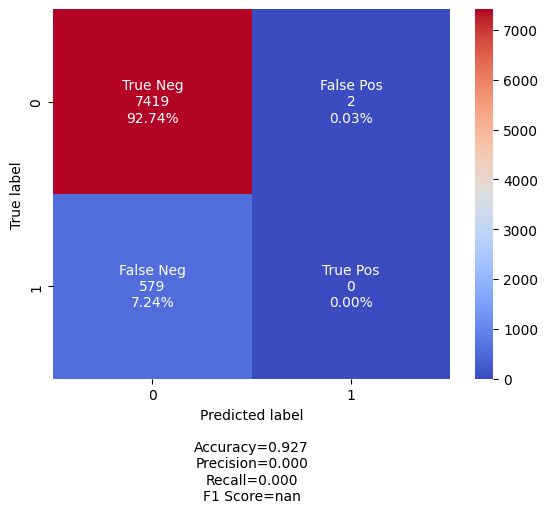

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_1=confusion_matrix(y_1_test,y_1_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_1,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_1_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.93      1.00      0.96      7421
         yes       0.00      0.00      0.00       579

    accuracy                           0.93      8000
   macro avg       0.46      0.50      0.48      8000
weighted avg       0.86      0.93      0.89      8000



Although we are able to get great accuracy for class 0 ('no'), we were not able to get a good accuracy for class 1 ('yes').

## Modeling: Layer 1

### Prepare Dataset for Modeling

Split data into training, validation, and testing sets:

In [199]:
data=pd.concat([X_1,y],axis=1)
data

,age,job,marital,education,default,balance,housing,loan,y
0,58,management,married,tertiary,no,2143,yes,no,0
1,44,technician,single,secondary,no,29,yes,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0
3,47,blue-collar,married,unknown,no,1506,yes,no,0
4,33,unknown,single,unknown,no,1,no,no,0
...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,0
39996,30,management,single,tertiary,no,3340,no,no,1
39997,54,admin,divorced,secondary,no,200,no,no,1
39998,34,management,married,tertiary,no,1047,no,no,0


Create function to speed up preparing data for modeling going forward:

In [200]:
cat_cols = list(X_1.select_dtypes(include='object').columns)
num_cols = list(X_1.select_dtypes(exclude='object').columns)

num_cols

['age', 'balance']

### Define and Run Functions for Modeling

Define code for preprocessing, modeling, and evaluation:

In [201]:
classifier_map={
    'etc':ExtraTreeClassifier(random_state=seed),
    'xgb':XGBClassifier(random_state=seed),
    'dtc':DecisionTreeClassifier(random_state=seed),
    'rfc':RandomForestClassifier(random_state=seed),
    'lgb':LGBMClassifier(random_state=seed,verbose=-1),
    'lrx':LogisticRegression(random_state=seed)
}

In [206]:
# Step 1: Split the data into training and testing sets
def split_data(data, target_column_name, random_state,test_size=0.2):
    print('Defining X...')
    X = data.drop(columns=[target_column_name])
    assert not X.isnull().any().any(), "X contains NaN values!"

    print('Defining y...')
    y = data[target_column_name]
    assert not y.isnull().any(), "y contains NaN values!"
  
    print('train_test_splitting...')
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    
    assert X_train.shape[0] + X_test.shape[0] == X.shape[0], "Train and test sizes do not match!"   
    return X_train,X_test,y_train,y_test

# Step 2: Create a function to transform the data
def transform_data(X_train, X_test, cat_cols):
    # One-hot encoding for categorical variables
    print('X_train encoding...')
    X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    assert X_train_encoded.shape[1] > 0, "X_train_encoded has no columns!"

    print('X_test encoding...')
    X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
    
    # Align columns with the training set to avoid mismatches
    print('Aligning columns...')
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    # Scaling
    scaler = StandardScaler()
    print('Scaling X_train...')
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    print('Scaling X_test...')
    X_test_scaled = scaler.transform(X_test_encoded)

    # Convert scaled arrays back to DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

    return X_train_scaled, X_test_scaled

# Step 3: Set up the RandomOverSampler
def oversample(X, y,random_state):
    ros = RandomOverSampler(random_state=random_state)
    print('Oversampling...')

    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Convert resampled arrays back to DataFrame
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

    # Assert to check if the resampling worked
    assert X_resampled.shape[0] > X.shape[0], "Oversampling did not increase the number of samples!"

    return X_resampled, y_resampled

# Step 4: Use 5-fold cross-validation and classification report
def evaluate_model(X_train, y_train, model,random_state):
    print(f'Evaluating model: {model}')
    
    # Initialize a StratifiedKFold object for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    all_y_true = []
    all_y_pred = []

    for train_index, test_index in skf.split(X_train, y_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # Fit the model on the training fold
        model.fit(X_cv_train, y_cv_train)
        
        # Make predictions on the validation fold
        y_cv_pred = model.predict(X_cv_test)

        # Collect the true and predicted values
        all_y_true.extend(y_cv_test)
        all_y_pred.extend(y_cv_pred)

        assert set(y_cv_test).issubset({0,1}),'y_cv_test contains unexpected values!'
    
    # Calculate evaluation metrics
    precision = precision_score(all_y_true, all_y_pred)
    recall = recall_score(all_y_true, all_y_pred)
    f1 = f1_score(all_y_true, all_y_pred)
    accuracy = accuracy_score(all_y_true, all_y_pred)

    results[model.__class__.__name__]={
        'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy
    }
    
    # Generate the classification report
    print(classification_report(all_y_true, all_y_pred))
    
    # Optionally: Calculate and print cross-validation scores
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()*100:.2f}%")
    
    assert len(all_y_true) == len(all_y_pred), "Mismatch between true and predicted values length!"

Defining X...
Defining y...
train_test_splitting...
X_train encoding...
X_test encoding...
Aligning columns...
Scaling X_train...
Scaling X_test...
Oversampling...

Evaluating etc on Train set:
Evaluating model: ExtraTreeClassifier(random_state=4769)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     29690
           1       0.92      1.00      0.96     29690

    accuracy                           0.95     59380
   macro avg       0.96      0.95      0.95     59380
weighted avg       0.96      0.95      0.95     59380

Cross-validation scores: [0.95520377 0.95486696 0.95444594 0.95528798 0.95469855]
Mean score: 95.49%

Evaluating etc on Test set:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7414
           1       0.13      0.17      0.15       586

    accuracy                           0.85      8000
   macro avg       0.53      0.54      0.53      8000
weighted avg       0

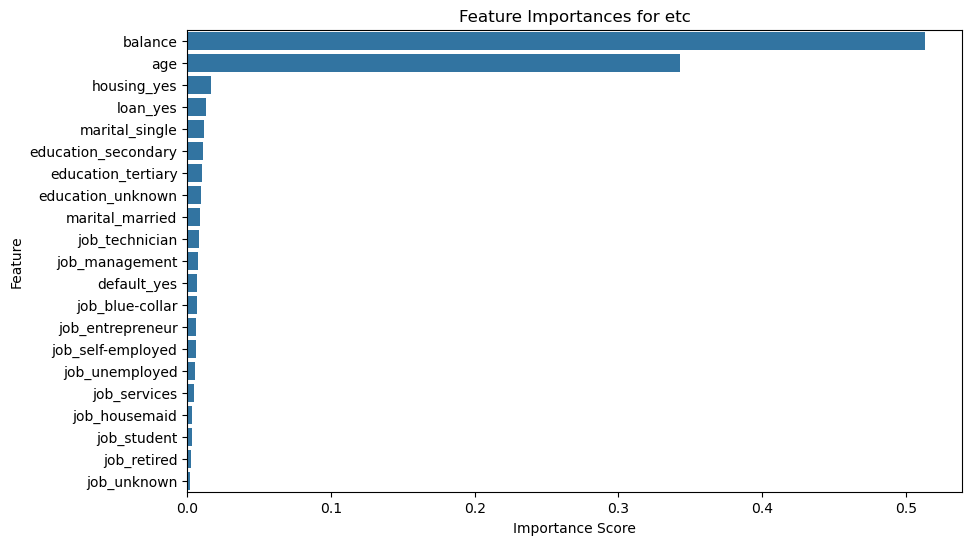


 ********************

Evaluating xgb on Train set:
Evaluating model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=4769, ...)
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     29690
           1       0.77      0.83      0.80     29690

    acc

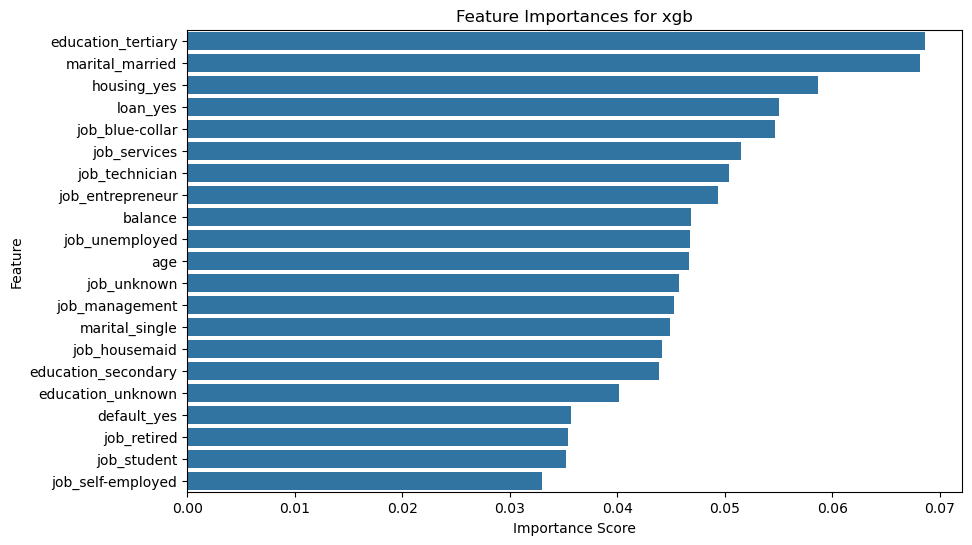


 ********************

Evaluating dtc on Train set:
Evaluating model: DecisionTreeClassifier(random_state=4769)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     29690
           1       0.91      1.00      0.96     29690

    accuracy                           0.95     59380
   macro avg       0.96      0.95      0.95     59380
weighted avg       0.96      0.95      0.95     59380

Cross-validation scores: [0.95225665 0.95663523 0.95444594 0.95183563 0.95259347]
Mean score: 95.36%

Evaluating dtc on Test set:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7414
           1       0.13      0.18      0.15       586

    accuracy                           0.85      8000
   macro avg       0.53      0.54      0.53      8000
weighted avg       0.87      0.85      0.86      8000



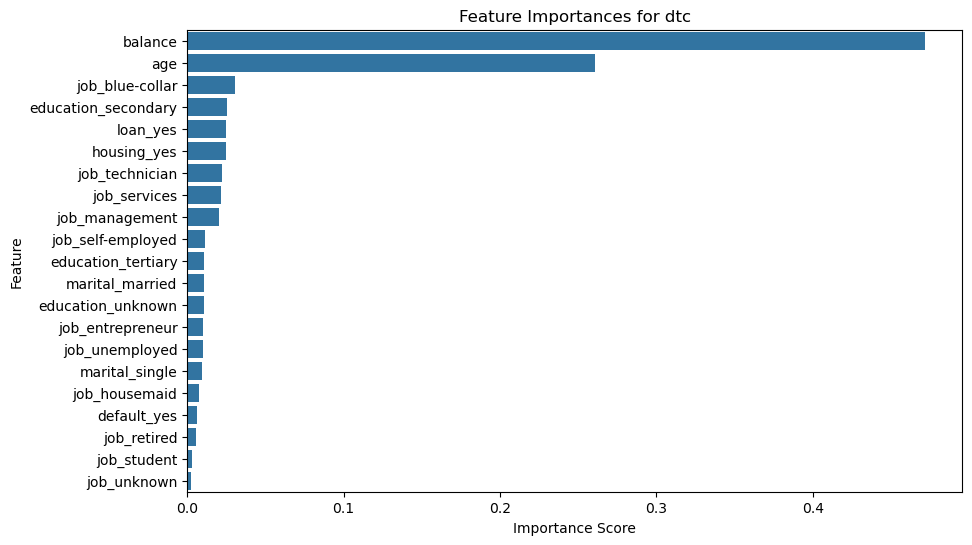


 ********************

Evaluating rfc on Train set:
Evaluating model: RandomForestClassifier(random_state=4769)
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     29690
           1       0.94      1.00      0.97     29690

    accuracy                           0.97     59380
   macro avg       0.97      0.97      0.97     59380
weighted avg       0.97      0.97      0.97     59380

Cross-validation scores: [0.96699225 0.96833951 0.9682553  0.96522398 0.96589761]
Mean score: 96.69%

Evaluating rfc on Test set:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7414
           1       0.15      0.15      0.15       586

    accuracy                           0.88      8000
   macro avg       0.54      0.54      0.54      8000
weighted avg       0.88      0.88      0.88      8000



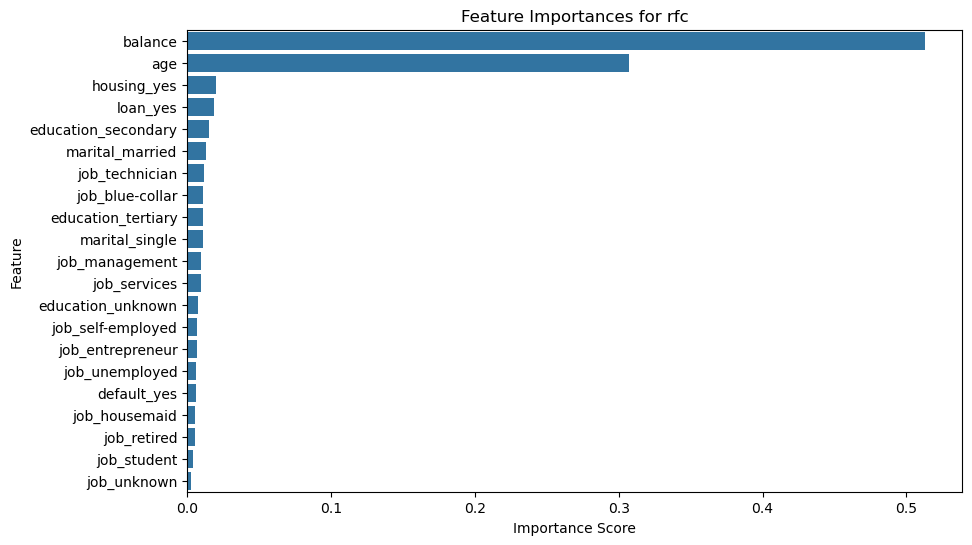


 ********************

Evaluating lgb on Train set:
Evaluating model: LGBMClassifier(random_state=4769, verbose=-1)
              precision    recall  f1-score   support

           0       0.73      0.71      0.72     29690
           1       0.72      0.74      0.73     29690

    accuracy                           0.73     59380
   macro avg       0.73      0.73      0.73     59380
weighted avg       0.73      0.73      0.73     59380

Cross-validation scores: [0.72027619 0.73400135 0.7181711  0.7304648  0.72212866]
Mean score: 72.50%

Evaluating lgb on Test set:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      7414
           1       0.11      0.47      0.18       586

    accuracy                           0.68      8000
   macro avg       0.53      0.58      0.49      8000
weighted avg       0.88      0.68      0.76      8000



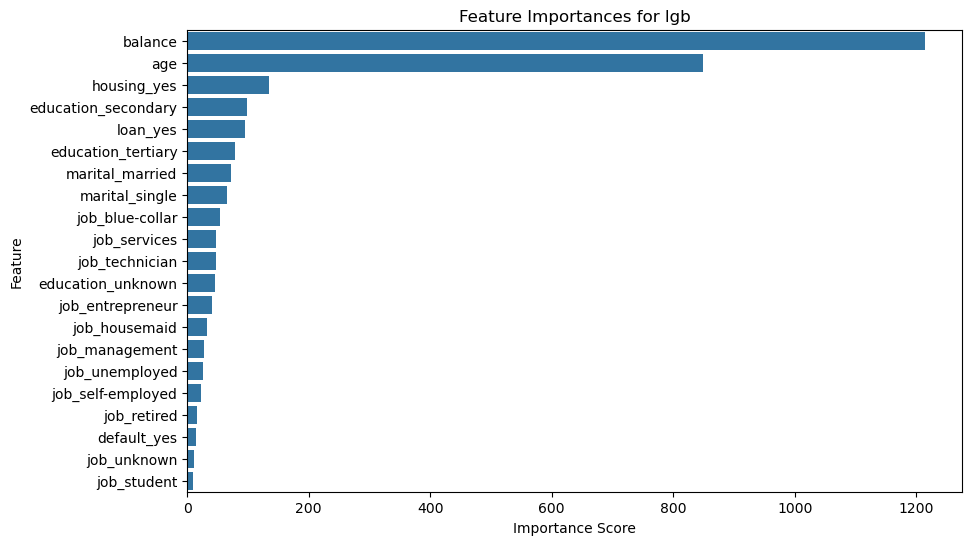


 ********************

Evaluating lrx on Train set:
Evaluating model: LogisticRegression(random_state=4769)
              precision    recall  f1-score   support

           0       0.58      0.61      0.59     29690
           1       0.59      0.55      0.57     29690

    accuracy                           0.58     59380
   macro avg       0.58      0.58      0.58     59380
weighted avg       0.58      0.58      0.58     59380

Cross-validation scores: [0.5784776  0.57999326 0.5808353  0.57957225 0.58428764]
Mean score: 58.06%

Evaluating lrx on Test set:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      7414
           1       0.10      0.55      0.17       586

    accuracy                           0.61      8000
   macro avg       0.52      0.58      0.46      8000
weighted avg       0.88      0.61      0.70      8000


 ********************
********************
Done!
********************


In [208]:
target_column_name='y'

# Splitting the data
X_train, X_test, y_train, y_test = split_data(data, target_column_name,random_state=seed)

# Transforming the data
X_train_scaled, X_test_scaled = transform_data(X_train, X_test, cat_cols)

# Oversampling the training data
X_train_resampled, y_train_resampled = oversample(X_train_scaled, y_train,random_state=seed)

results={}

for model_name, model in classifier_map.items():
    # Evaluate the model using cross-validation
    print(f'\nEvaluating {model_name} on Train set:')
    evaluate_model(X_train_resampled, y_train_resampled, model, random_state=seed)
    
    # Final evaluation on test set
    print(f'\nEvaluating {model_name} on Test set:')
    y_test_pred=model.predict(X_test_scaled)
    print(classification_report(y_test,y_test_pred))
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train_resampled.columns  # Now this will work correctly
        feature_importances_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort DataFrame by importance
        feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
        plt.title(f'Feature Importances for {model_name}')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.show()
        
    print('\n', '*' * 20)
    
print('*'*20)
print('Done!')
print('*'*20)

This is a good first step - we have classification reports for a suite of algorithms, along with the extracted feature importances for the models that support this feature. After completing this survey, we found that the `RandomForestClassifier` and `LGBMClassifier` performed the best.

Now we can evaluate the RFC model on the test set:

In [212]:
best_model=classifier_map['rfc']
best_model.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7414
           1       0.15      0.12      0.13       586

    accuracy                           0.89      8000
   macro avg       0.54      0.53      0.54      8000
weighted avg       0.87      0.89      0.88      8000



In [226]:
best_model=classifier_map['lgb']
best_model.fit(X_train_resampled,y_train_resampled)
y_test_pred=best_model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7421
           1       0.07      0.29      0.11       579

    accuracy                           0.66      8000
   macro avg       0.50      0.49      0.45      8000
weighted avg       0.86      0.66      0.74      8000



In [213]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [215]:
model=BalancedRandomForestClassifier(random_state=seed,sampling_strategy='all',replacement=True,bootstrap=False)
model.fit(X_train_resampled,y_train_resampled)
y_test_pred=model.predict(X_test_scaled)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7414
           1       0.15      0.12      0.13       586

    accuracy                           0.89      8000
   macro avg       0.54      0.53      0.54      8000
weighted avg       0.87      0.89      0.88      8000



### Optuna with RandomForestClassifier

In [217]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# Create a pipeline with RandomOverSampler and Tomek Links
resample_pipeline = Pipeline(steps=[
    ('oversample', RandomOverSampler(random_state=42)),
    ('tomek', TomekLinks(sampling_strategy='majority'))
])

# Resample only the training data
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_scaled, y_train)

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Create the RandomForest model with the suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Define macro-averaged F1-score and recall scorers
    f1_scorer = make_scorer(f1_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation and compute both F1-score and recall
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    f1_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                scoring=f1_scorer, cv=cv)
    recall_scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                    scoring=recall_scorer, cv=cv)

    # Compute a weighted combination of F1-score and recall
    f1_mean = f1_scores.mean()
    recall_mean = recall_scores.mean()
    
    combined_score = 0.6 * f1_mean + 0.4 * recall_mean  # Adjust weights as needed

    return combined_score

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best trial:")
print(study.best_trial.params)

# Train the final model with the best hyperparameters
best_params = study.best_trial.params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Evaluate using classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[I 2024-10-24 15:07:38,721] A new study created in memory with name: no-name-0ebb5770-1ff1-4f21-94de-44e3cdb154f9
[I 2024-10-24 15:08:50,839] Trial 0 finished with value: 0.6086987616090671 and parameters: {'n_estimators': 279, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.6086987616090671.
[I 2024-10-24 15:11:06,491] Trial 1 finished with value: 0.8530655961419586 and parameters: {'n_estimators': 288, 'max_depth': 15, 'min_samples_split': 15}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:11:45,378] Trial 2 finished with value: 0.6082169789081949 and parameters: {'n_estimators': 151, 'max_depth': 6, 'min_samples_split': 12}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:12:07,039] Trial 3 finished with value: 0.5963402199168595 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_split': 14}. Best is trial 1 with value: 0.8530655961419586.
[I 2024-10-24 15:13:37,894] Trial 4 finished with value: 0.678237454128

Best trial:
{'n_estimators': 121, 'max_depth': 20, 'min_samples_split': 4}


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- default
- education
- housing
- job
- loan
- ...
Feature names seen at fit time, yet now missing:
- default_yes
- education_secondary
- education_tertiary
- education_unknown
- housing_yes
- ...


In [218]:
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter suggestions from Optuna
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Define the RandomForest model with suggested parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=seed
    )

    # Create a pipeline with RandomOverSampler and Tomek Links
    pipeline = Pipeline([
        ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=seed)),
        ('tomek', TomekLinks()),
        ('classifier', model)
    ])

    # Define macro-averaged F1-score and recall scorers
    f1_scorer = make_scorer(f1_score, average='macro')
    recall_scorer = make_scorer(recall_score, average='macro')

    # Perform cross-validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv)
    recall_scores = cross_val_score(pipeline, X_train, y_train, scoring=recall_scorer, cv=cv)

    # Compute a weighted score combining F1 and recall
    f1_mean = f1_scores.mean()
    recall_mean = recall_scores.mean()

    combined_score = 0.4 * f1_mean + 0.6 * recall_mean  # Adjust weights as needed

    return combined_score

# Create the Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Print the best trial's parameters
print("Best trial:")
print(study.best_trial.params)

# Train the final model with the best parameters
best_params = study.best_trial.params
final_model = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='minority', random_state=seed)),
    ('tomek', TomekLinks()),
    ('classifier', RandomForestClassifier(**best_params, random_state=seed))
])
final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[I 2024-10-24 16:12:31,199] A new study created in memory with name: no-name-1103519c-a5f9-45b6-b701-1273f1b80e0d
[W 2024-10-24 16:12:31,558] Trial 0 failed with parameters: {'n_estimators': 236, 'max_depth': 8, 'min_samples_split': 6} because of the following error: ValueError('\nAll the 15 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n15 fits failed with the following error:\nTraceback (most recent call last):\n  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper\n    return fit_method(estimator, *args, **kw

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 106, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/imblearn/base.py", line 161, in _check_X_y
    X, y = self._validate_data(X, y, reset=True, accept_sparse=accept_sparse)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/sklearn/utils/_array_api.py", line 751, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Applications/Anaconda/anaconda3/envs/apziva/lib/python3.9/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'blue-collar'


In [225]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define your preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# Function to apply resampling only on the training data
def resample_data(X, y):
    X_res, y_res = RandomOverSampler(random_state=seed).fit_resample(X, y)
    X_res, y_res = TomekLinks(sampling_strategy='not majority').fit_resample(X_res, y_res)
    return X_res, y_res

# Wrap the resampling logic in FunctionTransformer
resample_transformer = FunctionTransformer(lambda X: X, validate=False)

# Create the full pipeline
model_pipeline = SklearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resample', resample_transformer),  # Wrapper to skip transformation
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

# Apply resampling on the training data only
X_train_res, y_train_res = resample_data(X_train, y_train)

# Fit the model on resampled training data
model_pipeline.fit(X_train_res, y_train_res)

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))


ValueError: could not convert string to float: 'admin'

## Modeling: Layer 2

### Layer 2: Use the full X dataset to model which customers the bank should keep calling

In [ ]:
X_2.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1


In [ ]:
splits_2,pipeline_2,results_2=\
run_autosklearn_pipeline(X=X_2,
                         y=y,
                         seed=seed,
                         verbose=True,
                         test_size=test_size,
                         save_location='../joblib/',
                         filename='2_pipeline_20240821_layer2',
                         time_for_task=3600)

Categorical and continuous features detected
Preprocessor created
categorical_features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
continuous_features: ['age', 'balance', 'day', 'duration', 'campaign']
Training and testing splits created
AutoSklearnClassifier and pipeline created

Training the pipeline... (This may take up to 60 minutes)




In [ ]:
results_2=returnTopModels('../joblib/2_pipeline_20240821_layer2')
results_2

random_forest          23
mlp                     5
liblinear_svc           3
k_nearest_neighbors     2
extra_trees             2
passive_aggressive      1
gaussian_nb             1
bernoulli_nb            1
Name: param_classifier:__choice__, dtype: int64

In [ ]:
pipeline_2=joblib.load('../joblib/2_pipeline_20240821_layer2')
splits_2=joblib.load('../joblib/2_pipeline_20240821_layer2_splits')

In [ ]:
X_2_test=splits_2['X_test']
y_2_test=splits_2['y_test']

y_2_pred,accuracy_2=evaluateModel(X_2_test,y_2_test,pipeline_2,verbose=True)

AutoSklearn accuracy:
93.77%


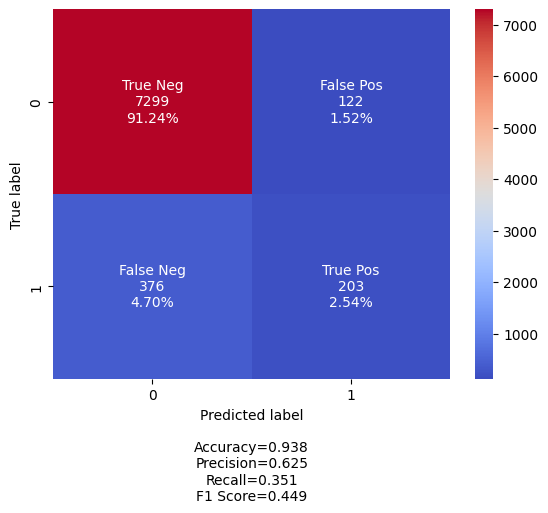

In [ ]:
# view confusion matrix
# the F1-score doesn't show but that's ok
cf_matrix_2=confusion_matrix(y_2_test,y_2_pred)
labels=['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf=cf_matrix_2,
                      group_names=labels,
                      cmap='coolwarm')

In [ ]:
# view F1-score
creport=classification_report(y_test,y_2_pred)
print(creport)

              precision    recall  f1-score   support

          no       0.95      0.98      0.97      7421
         yes       0.62      0.35      0.45       579

    accuracy                           0.94      8000
   macro avg       0.79      0.67      0.71      8000
weighted avg       0.93      0.94      0.93      8000



This is also a great result.